<a href="https://colab.research.google.com/github/joskid/035-building-an-online-store-part-2-creating-context-using-hooks/blob/master/convolutional_neural_nets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands on with Convolutional Neural Networks 
#### _Detecting the wonders of world_

How to use this notebook:
1. Download the data from https://drive.google.com/drive/u/0/folders/1nOBfqHc80kjr3leGguopmSBifYDQfqqQ and put it into your google drive (Ideally under "My Drive/DeepFindr/CNN")
2. Run the cell block "Installing Pytorch, enabling GPU ..." and connect to your google drive
3. You might have to adjust the paths in this notebook if you have stored the data somewhere else then the above location.

## Installing Pytorch, enabling GPU and accessing the Data on Google Drive

In [ ]:
# Pytorch is already installed on colab, so no pip install :)
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
 
# Set GPU device
print(torch.cuda.is_available())
device = torch.device("cuda:0")

True


In [ ]:
# Connect Google Drive with colab (follow the instructions)
from google.colab import drive
drive.mount('/content/google_drive')

Mounted at /content/google_drive


Now we can access the data under /content/google_drive

## Visualizing the Convolution - A simple edge filter

First let's have a look at what Filters actually do when applied to an image

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img_path_pyramid = '/content/google_drive/My Drive/DeepFindr/CNN/test/great_pyramid_of_giza/giza-1756946_1280.jpg'

# Read as numpy image
img = mpimg.imread(img_path_pyramid) 
# Decrease the dimension of the image (more suitable for filter)
img = img[::7, ::7, :]

# Show the pixel values Red / Green / Blue for the first 5 pixels
print(img[0, :5])

In [ ]:
# Display the image
plt.imshow(img)

Now we will use one of the two filters of the so called Sobel filter. Find more details [here](https://medium.com/datadriveninvestor/understanding-edge-detection-sobel-operator-2aada303b900).

In order to > apply it < we simply slide the filter over the image and multiply it with the corresponding area and sum up the values.

In [ ]:
import numpy as np
import copy

# Define the 3x3 filter (Gradient for x-direction from Sobel filter)
filter = [[1, 0, -1],
          [1, 0, -1],
          [1, 0, -1]]

# Create placeholder for filtered image
filtered_image = np.full((img.shape[0] - 2, img.shape[1] - 2, 3), 0).astype(int)

for row in range(img.shape[0]): # stride is 1
  for col in range(img.shape[1]): # stride is 1
    if row > 2 and col > 2:
      # Apply filter on first channel of image
      filtered_image[row - 2:row, col - 2:col, :] =  np.sum(img[row -3 :row, col - 3:col, 0] * filter).astype(int)  

Now we can see that the information we look for has been _filtered_ out. Note that our filter is a little bit small for the image size and therefore we also detect smaller edges. Also, we currently only detect edges in the x-direction as we have only applied one filter from the Sobel filter.
Also note how the resolution of the image decreased.

In [ ]:
# Display detected edges (x-direction)
plt.imshow(filtered_image, vmin=filtered_image.min(), vmax=filtered_image.max())
filtered_image.shape

These filters will be learned by the CNN, which means we are capable of detecting pretty much _any_ local as well as global patterns on the image. 

## Manually loading the data and displaying it

- We don't have to loop manually over the files to load them for Pytorch (there is a dedicated function for this)
- But first we quickly want to investigate samples of our data
- Small dataset
- Only 80 images in total, 10 per label

In [ ]:
# Paths and placeholders for files
train_root = "/content/google_drive/My Drive/DeepFindr/CNN/train"
test_root = "/content/google_drive/My Drive/DeepFindr/CNN/test"
train_path_dict = {}
test_path_dict = {}

Here we loop over all files and store their path in the dictionary.

In [ ]:
import os

# Go through all train folders
for subdir, dirs, files in os.walk(train_root):
    wonder = subdir.split("/")[-1]
    paths = []
    for file in files:
        paths.append(os.path.join(subdir, file))
    if wonder != "train":
        train_path_dict[wonder] = paths

# Go through all test folders
for subdir, dirs, files in os.walk(test_root):
    wonder = subdir.split("/")[-1]
    paths = []
    for file in files:
        paths.append(os.path.join(subdir, file))
    if wonder != "test":
        test_path_dict[wonder] = paths

# Show example
test_path_dict

{'chichen_itza': ['/content/google_drive/My Drive/DeepFindr/CNN/test/chichen_itza/pyramid-1093924_1280.jpg',
  '/content/google_drive/My Drive/DeepFindr/CNN/test/chichen_itza/chichen-itza-683193_1280.jpg'],
 'christ_the_redeemer_rio': ['/content/google_drive/My Drive/DeepFindr/CNN/test/christ_the_redeemer_rio/pexels-photo-2818895.jpeg',
  '/content/google_drive/My Drive/DeepFindr/CNN/test/christ_the_redeemer_rio/pexels-photo-2868248.jpeg'],
 'city_of_petra': ['/content/google_drive/My Drive/DeepFindr/CNN/test/city_of_petra/petra-2067946_1280.jpg',
  '/content/google_drive/My Drive/DeepFindr/CNN/test/city_of_petra/petra-jordan-543450_1280.jpg'],
 'colosseum_rome': ['/content/google_drive/My Drive/DeepFindr/CNN/test/colosseum_rome/italy-2478805_1280.jpg',
  '/content/google_drive/My Drive/DeepFindr/CNN/test/colosseum_rome/colosseum-3676165_1280.jpg'],
 'great_pyramid_of_giza': ['/content/google_drive/My Drive/DeepFindr/CNN/test/great_pyramid_of_giza/giza-1756946_1280.jpg',
  '/content/go

- Randomly select images from the different folders and display them in a grid
- Some of the images might appear twice :)

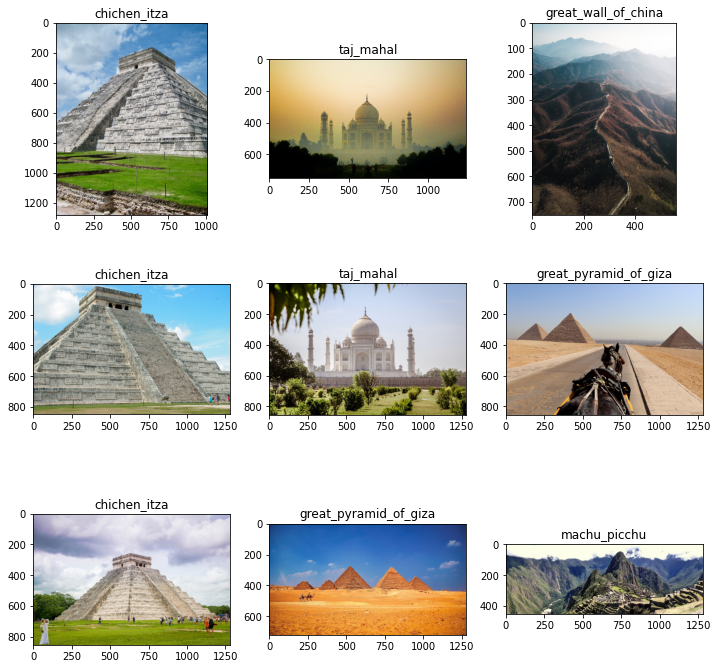

In [ ]:
import matplotlib.pyplot as plt
import random

num_images_per_axis = 3
figsize = (12,12)
figure = plt.figure(figsize=figsize)

for i in range(num_images_per_axis**2):
  ax = figure.add_subplot(num_images_per_axis, num_images_per_axis, i+1)
  # Randomly select wonder
  wonder_type = random.choice(list(train_path_dict.keys()))
  ax.title.set_text(wonder_type)
  # Select random file index
  index = random.choice(range(0,7))
  img = plt.imread(train_path_dict[wonder_type][index])
  ax.imshow(img)

Observations:
- RGB images with 3 color channels --> Our our data shape is (width, height, channel=3)
- Different sizes for the images --> We will need to adjust the sizes later
- 8 train images per label, 2 test images per label --> We will use two images to test how our model performs

## Pytorch Dataset and Pytorch DataLoader

- There exist already a lot predefined procedures to easily load data, for example ImageFolder
- ImageFolder will create a dataset for us
- The folder name will automatically be used as class label
- We use a 80/20 train test split here and have 2 separate datasets
- We apply a resizing on the images
- Alternative of Risizing would be cropping or padding!


### Dataset

In [ ]:
# Load train dataset
train_dataset = torchvision.datasets.ImageFolder(
        root=train_root, # This is the folder containing the image-folders
        transform=transforms.Compose([
                      transforms.Resize((512,512)),
                      transforms.ToTensor()
        ])
)

Having a look at the dataset...

In [ ]:
print("Dataset >>> ", train_dataset)
print("Sample >>> ", train_dataset[0])
print("Sample shape Channels x Height x Width >>> ", train_dataset[0][0].size())

Dataset >>>  Dataset ImageFolder
    Number of datapoints: 64
    Root location: /content/google_drive/My Drive/DeepFindr/CNN/train
    StandardTransform
Transform: Compose(
               Resize(size=(512, 512), interpolation=PIL.Image.BILINEAR)
               ToTensor()
           )
Sample >>>  (tensor([[[0.6510, 0.6549, 0.6549,  ..., 0.6863, 0.6824, 0.6784],
         [0.6510, 0.6510, 0.6549,  ..., 0.6863, 0.6863, 0.6824],
         [0.6471, 0.6510, 0.6510,  ..., 0.6863, 0.6863, 0.6824],
         ...,
         [0.4000, 0.4157, 0.3961,  ..., 0.3765, 0.3843, 0.4353],
         [0.4039, 0.4235, 0.4039,  ..., 0.3412, 0.3725, 0.4353],
         [0.3882, 0.4196, 0.4039,  ..., 0.3020, 0.3373, 0.3882]],

        [[0.6392, 0.6431, 0.6431,  ..., 0.6980, 0.6941, 0.6902],
         [0.6392, 0.6392, 0.6431,  ..., 0.6980, 0.6980, 0.6941],
         [0.6353, 0.6392, 0.6392,  ..., 0.6980, 0.6980, 0.6941],
         ...,
         [0.4706, 0.4863, 0.4667,  ..., 0.4471, 0.4510, 0.5020],
         [0.4745, 0.4

- ToTensor automatically converts Images to [0,1] 
- Labels are automatically converted to numbers
- ImageFolder uses the foldername as class label
- Indexing the Dataset will return a tuple (image, label)
- Pytorch uses PIL (Python Imaging Library) in the background
- By default the channel is the first dimension in Pytorch Tensors

In [ ]:
# Load test dataset
test_dataset = torchvision.datasets.ImageFolder(
        root=test_root,
        transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Resize((512,512))
        ])
    )
test_dataset

Dataset ImageFolder
    Number of datapoints: 16
    Root location: /content/google_drive/My Drive/DeepFindr/CNN/test
    StandardTransform
Transform: Compose(
               ToTensor()
               Resize(size=(512, 512), interpolation=PIL.Image.BILINEAR)
           )

### Data Loaders
they help us with
- efficiently looping over the data
- multi-processing
- batching (loading subsets of the dataset)
- ...

We need to pass the previously generated dataset to this dataloader

In [ ]:
batch_size = 8
# Create the train dataloader
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True
)
# Create the test dataloader
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)


## Training a Convolutional Neural Network

Building a CNN model

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        # Initialize super class
        super(CNN, self).__init__()

        # Define architecture of CNN
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=2)
        self.conv4 = nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Classifier, Input are 30 Feature maps with 128 x 128 values
        self.fc1 = nn.Linear(30 * 128 * 128, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 8)

    def forward(self, x):
        # Feature extraction
        x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
        x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))

        # Flatten and feed to classifier
        x = x.flatten(start_dim=1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = CNN()
net = net.to(device)
net

CNN(
  (conv1): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv4): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=491520, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=8, bias=True)
)

### CNN with Sequential

In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.cnn = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=5, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=5, out_channels=10, kernel_size=3, padding=1), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=20, out_channels=30, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
            )

        self.classifier = nn.Sequential(
              nn.Linear(30 * 128 * 128, 120),
              nn.Linear(120, 84),
              nn.Linear(84, 8)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = x.flatten(start_dim=1)
        x = self.classifier(x)
        return x

net = CNN()
net = net.to(device)
net

CNN(
  (cnn): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (6): ReLU(inplace=True)
    (7): Conv2d(20, 30, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=491520, out_features=120, bias=True)
    (1): Linear(in_features=120, out_features=84, bias=True)
    (2): Linear(in_features=84, out_features=8, bias=True)
  )
)

### Defining the Optimizer and Loss function

In [ ]:
import torch.optim as optim
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

- Cross entropy loss applies softmax implicitly
- Adam is generally a good choice as optimizer

In [ ]:
def train_model(early_stopping=True, epochs=50):
  """ Training the model in a loop of epochs """
  epoch_train_losses = []
  epoch_test_losses = []
  current_best_loss = np.inf
  early_stopping_counter = 0
  early_stopping_patience = 2

  # loop over the dataset multiple times
  for epoch in range(epochs):  
    for i, batch in enumerate(train_loader, 0):
        # get the inputs - data is a list of [inputs, labels]
        inputs, labels = batch
        # Put data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        # Implicitly uses softmax
        loss = cross_entropy_loss(outputs, labels)
        loss.backward()
        optimizer.step()
    # Print loss stats every x epochs
    if epoch % 1 == 0: 
      # Convert outputs
      outputs = output_to_label(outputs)
      # Calculate train accuracy
      train_acc = calculate_accuracy(labels.detach().cpu().numpy(), outputs)
      test_acc, test_loss = test()
      print(f"Epoch: {epoch} | train_loss: {loss} | train_acc: {train_acc} \
      | test_loss: {test_loss} | test_acc: {test_acc}")
      epoch_train_losses.append(loss.item())
      epoch_test_losses.append(test_loss)

      # Early stopping
      if test_loss < current_best_loss:
        current_best_loss = test_loss
        early_stopping_counter = 0
      else:
        early_stopping_counter += 1
        if early_stopping_counter >= early_stopping_patience and early_stopping:
          break

  print('Finished Training')
  return epoch_train_losses, epoch_test_losses

def calculate_accuracy(labels, predictions):
  """ Calculates the % of correct predictions """
  labels = np.asarray(labels)
  predictions = np.asarray(predictions)
  correct = (labels == predictions)
  return correct.sum() / correct.size

def test():
  """ Evaluating the model on the test data """

  all_labels = []
  all_predictions = []
  all_losses = []

  # Iterate over batches of test loader
  for i, batch in enumerate(test_loader, 0):
        # get the inputs - data is a list of [inputs, labels]
        inputs, labels = batch
        # Put data to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)
        # Get the output
        outputs = net(inputs)
        # Calculate loss
        loss = cross_entropy_loss(outputs, labels)
        all_losses.append(loss.item())
        # Convert outputs 
        outputs = output_to_label(outputs)
        all_labels.extend(labels.detach().cpu().numpy())
        all_predictions.extend(outputs)
  # Calculate accuracy with all test data
  test_acc = calculate_accuracy(all_labels, all_predictions)
  return test_acc, sum(all_losses)/len(test_loader)

def output_to_label(output):
  # Apply softmax
  outputs_prob = F.softmax(output)
  return np.argmax(outputs_prob.detach().cpu().numpy(), axis=1)

In [ ]:
epoch_train_losses, epoch_test_losses = train_model()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0 | train_loss: 2.1807446479797363 | train_acc: 0.0       | test_loss: 2.0935913920402527 | test_acc: 0.1875
Epoch: 1 | train_loss: 2.067931890487671 | train_acc: 0.375       | test_loss: 2.0605872869491577 | test_acc: 0.3125
Epoch: 2 | train_loss: 1.8101290464401245 | train_acc: 0.25       | test_loss: 1.9724181294441223 | test_acc: 0.1875
Epoch: 3 | train_loss: 1.6939221620559692 | train_acc: 0.5       | test_loss: 1.836234211921692 | test_acc: 0.25
Epoch: 4 | train_loss: 1.3766133785247803 | train_acc: 0.625       | test_loss: 1.803267478942871 | test_acc: 0.3125
Epoch: 5 | train_loss: 1.4379982948303223 | train_acc: 0.5       | test_loss: 1.6525098085403442 | test_acc: 0.4375
Epoch: 6 | train_loss: 0.5566401481628418 | train_acc: 0.875       | test_loss: 1.7033458948135376 | test_acc: 0.25
Epoch: 7 | train_loss: 0.5405712127685547 | train_acc: 0.875       | test_loss: 1.5073989629745483 | test_acc: 0.4375
Epoch: 8 | train_loss: 0.4077080488204956 | train_acc: 1.0       | tes

### Visualizing the training

In [ ]:
import seaborn as sns
sns.set_style("darkgrid")
import pandas as pd

def visualize_losses():
  losses_tr = pd.DataFrame(columns=["loss_val", "type"])
  losses_tr["loss_val"] = epoch_train_losses
  losses_tr["type"] = "train"
  losses_ts = pd.DataFrame(columns=["loss_val", "type"])
  losses_ts["loss_val"] = epoch_test_losses
  losses_ts["type"] = "test"
  all_losses = pd.concat([losses_tr, losses_ts])
  sns.lineplot(data=all_losses, x=all_losses.index, y="loss_val", hue="type")
  plt.show()

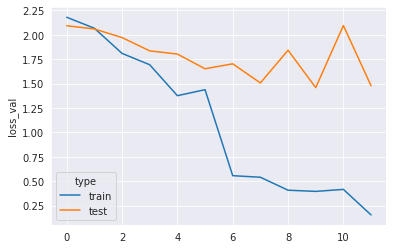

In [ ]:
visualize_losses()

Note: Ideally we should take the model parameters with the best loss here. But instead I will just take the last model parameters for predicting.

## Investigating the predictions

In [ ]:
import numpy as np

# Get next batch 
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)

# Get outputs of model
outputs = net(images)
labels = np.array(labels)

# Cross Entropy loss already applied Softmax, now we need to do it manually
outputs_prob = F.softmax(outputs).detach().cpu().numpy()
# Get most likely class
outputs = np.argmax(outputs_prob, axis=1)
probabilities = np.max(outputs_prob, axis=1)

# Print class probabilities, predictions and ground truths
print(outputs_prob)
print(outputs)
print(labels)

# Map the numeric values back to classes
txt_labels = list(train_dataset.class_to_idx.keys())
outputs = [txt_labels[i] for i in outputs]
labels = [txt_labels[i] for i in labels]

[[1.45753351e-04 1.80147476e-02 2.07831559e-04 3.08769010e-03
  7.57939517e-07 6.02404654e-01 3.72838169e-01 3.30045796e-03]
 [1.15747117e-02 1.11218821e-03 3.16463709e-01 1.53678311e-02
  2.93998572e-04 1.63792208e-01 4.91265744e-01 1.29698412e-04]
 [4.49982770e-02 1.43376761e-03 3.41949277e-02 2.73979843e-01
  5.17508686e-01 8.13928097e-02 4.40549962e-02 2.43671588e-03]
 [7.90175050e-02 3.92018526e-04 8.91382575e-01 5.54477656e-03
  4.19005548e-04 6.38020318e-03 5.16641699e-03 1.16975242e-02]
 [1.83838196e-02 5.21807410e-02 1.66181281e-01 6.79163858e-02
  1.46368355e-03 4.86278743e-01 1.84556141e-01 2.30392441e-02]
 [2.21562877e-01 1.22140255e-02 2.67005228e-02 3.14063914e-02
  1.32722466e-03 8.19623321e-02 6.05942635e-03 6.18767202e-01]
 [2.44314522e-02 6.83717877e-02 2.33993270e-02 5.65281361e-02
  4.77432593e-04 5.73413849e-01 1.18340015e-01 1.35037988e-01]
 [6.36701137e-02 1.57993734e-02 3.22775453e-01 5.05330712e-02
  2.08860525e-04 1.75673023e-01 3.65638375e-01 5.70174539e-03]]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  del sys.path[0]


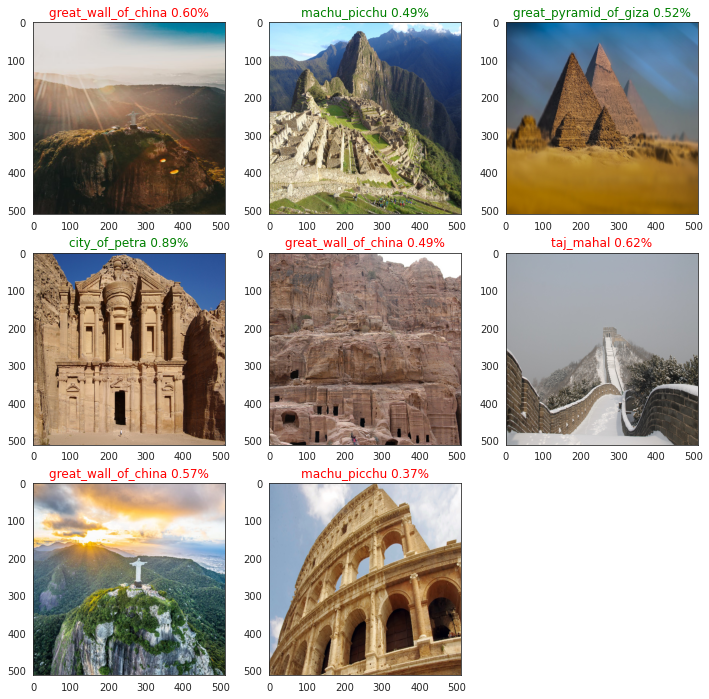

In [ ]:
sns.set_style("white")
figsize = (12,12)
figure = plt.figure(figsize=figsize)

for i in range(batch_size):
  ax = figure.add_subplot(num_images_per_axis, num_images_per_axis, i+1)
  wonder_type = outputs[i]
  groundtruth = labels[i]
  if groundtruth == wonder_type:
    color = "green"
  else:
    color = "red"
  img = images[i]
  img = img.permute(1,2,0).detach().cpu().numpy()
  ax.set_title(wonder_type + f" {probabilities[i]:.2f}%", color=color)
  ax.imshow(img)

The best accuracy we have so far is ~50 %.
**Can we do better?**

## Data Augmentation - Generating "new" data

- We can try to increase the variance in the images to make the model better generalize
- This can be simple operations such as roating the image or flipping it
- There exist a lot of possibilities for data augmentation ([here](https://pytorch.org/docs/stable/torchvision/transforms.html))


In [ ]:
# Augmentation of the train dataset
augmented_train_dataset = torchvision.datasets.ImageFolder(
        root=train_root,
        transform=transforms.Compose([
                      transforms.RandomResizedCrop((512,512), scale=(0.5, 1.0)),
                      transforms.RandomRotation(10),
                      transforms.RandomHorizontalFlip(),
                      transforms.ToTensor(),
        ])
)

batch_size = 8
# Create the train dataloader
train_loader = torch.utils.data.DataLoader(
    augmented_train_dataset,
    batch_size=batch_size,
    shuffle=True
)

How do the augmented train images look like?

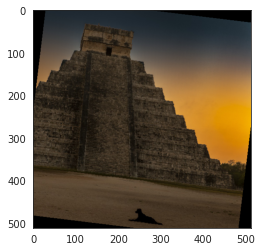

In [ ]:
sample = iter(train_loader).next()[0][0]
first_image = sample.permute(1,2,0).detach().cpu().numpy()
plt.imshow(first_image)

In [ ]:
# Reinitialize / Reset the model and weights
net = CNN()
net.to(device)
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

epoch_train_losses, epoch_test_losses = train_model(early_stopping=False)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0 | train_loss: 2.7369678020477295 | train_acc: 0.125       | test_loss: 2.721422553062439 | test_acc: 0.25
Epoch: 1 | train_loss: 2.260901927947998 | train_acc: 0.125       | test_loss: 2.255523443222046 | test_acc: 0.25
Epoch: 2 | train_loss: 1.8985378742218018 | train_acc: 0.0       | test_loss: 1.9663069248199463 | test_acc: 0.3125
Epoch: 3 | train_loss: 2.441560983657837 | train_acc: 0.125       | test_loss: 2.0036641359329224 | test_acc: 0.1875
Epoch: 4 | train_loss: 1.8222887516021729 | train_acc: 0.375       | test_loss: 1.8649630546569824 | test_acc: 0.25
Epoch: 5 | train_loss: 1.8360828161239624 | train_acc: 0.25       | test_loss: 1.858944594860077 | test_acc: 0.25
Epoch: 6 | train_loss: 1.929137945175171 | train_acc: 0.25       | test_loss: 1.822037160396576 | test_acc: 0.3125
Epoch: 7 | train_loss: 1.8243513107299805 | train_acc: 0.5       | test_loss: 1.8121437430381775 | test_acc: 0.3125
Epoch: 8 | train_loss: 1.3805595636367798 | train_acc: 0.75       | test_loss

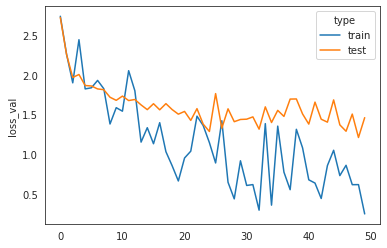

In [ ]:
visualize_losses()

Print sample predictions

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':


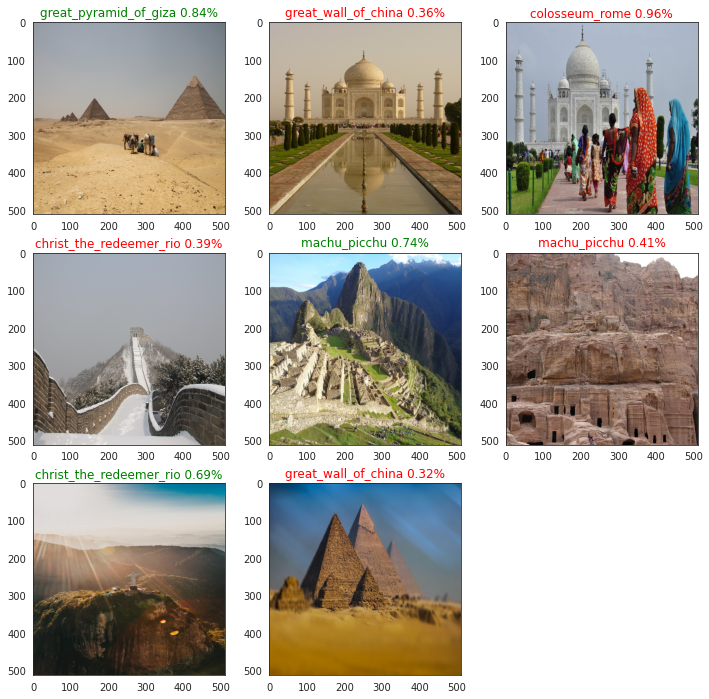

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)

outputs = net(images)
labels = np.array(labels)

# Cross Entropy loss already applied Softmax, now we need to do it manually
outputs_prob = F.softmax(outputs).detach().cpu().numpy()
# Get most likely class
outputs = np.argmax(outputs_prob, axis=1)
probabilities = np.max(outputs_prob, axis=1)

# Map the numeric values back to classes
txt_labels = list(train_dataset.class_to_idx.keys())
outputs = [txt_labels[i] for i in outputs]
labels = [txt_labels[i] for i in labels]
sns.set_style("white")
figsize = (12,12)
figure = plt.figure(figsize=figsize)

for i in range(batch_size):
  ax = figure.add_subplot(num_images_per_axis, num_images_per_axis, i+1)
  wonder_type = outputs[i]
  groundtruth = labels[i]

  if groundtruth == wonder_type:
    color = "green"
  else:
    color = "red"

  img = images[i]
  img = img.permute(1,2,0).detach().cpu().numpy()
  ax.set_title(wonder_type + f" {probabilities[i]:.2f}%", color=color)
  ax.imshow(img)

Now we managed to improve the performance to 0.56%. Can we do even better?

## Transfer Learning - Using pretrained models

In [ ]:
# Augmentation of the train dataset
augmented_train_dataset = torchvision.datasets.ImageFolder(
        root=train_root,
        transform=transforms.Compose([
                      transforms.RandomResizedCrop((512,512), scale=(0.2, 1.0)),
                      transforms.RandomRotation(20),
                      transforms.RandomHorizontalFlip(),
                      transforms.ToTensor(),
                      # Required for ImageNet models
                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
)

batch_size = 8
# Create the train dataloader
train_loader = torch.utils.data.DataLoader(
    augmented_train_dataset,
    batch_size=batch_size,
    shuffle=True
)



# Also apply normalization to the test dataset
test_dataset = torchvision.datasets.ImageFolder(
        root=test_root,
        transform=transforms.Compose([
                      transforms.ToTensor(),
                      transforms.Resize((512,512)),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    )

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=True
)

In [ ]:
import torchvision.models as models
class PretrainedCNN(nn.Module):
    def __init__(self):
        super(PretrainedCNN, self).__init__()
        # Also try resnext50_32x4d
        self.pretrained = models.vgg16(pretrained=True) 

        # We can freeze the parameters and don't need to calculate gradients
        for param in self.pretrained.parameters():
          param.requires_grad = False

        # For resnext50_32x4d fc instead of classifier[6]
        in_feats = self.pretrained.classifier[6].in_features 
        
        # Adjust output layer - the only place where learning happens
        self.pretrained.classifier[6] = nn.Linear(in_feats, 8)


    def forward(self, x):
        x = self.pretrained(x)
        return x

net = PretrainedCNN()
net.to(device)

PretrainedCNN(
  (pretrained): VGG(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
 

In [ ]:
cross_entropy_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
epoch_train_losses, epoch_test_losses = train_model(early_stopping=False, epochs=8)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 0 | train_loss: 2.1734604835510254 | train_acc: 0.25       | test_loss: 1.5796453952789307 | test_acc: 0.5625
Epoch: 1 | train_loss: 1.3297189474105835 | train_acc: 0.5       | test_loss: 1.222325086593628 | test_acc: 0.6875
Epoch: 2 | train_loss: 0.9127694368362427 | train_acc: 0.75       | test_loss: 1.0262081325054169 | test_acc: 0.625
Epoch: 3 | train_loss: 0.5512778759002686 | train_acc: 1.0       | test_loss: 0.9038037061691284 | test_acc: 0.6875
Epoch: 4 | train_loss: 0.5714024901390076 | train_acc: 1.0       | test_loss: 0.8539271354675293 | test_acc: 0.8125
Epoch: 5 | train_loss: 0.7491124868392944 | train_acc: 0.75       | test_loss: 0.7681804299354553 | test_acc: 0.6875
Epoch: 6 | train_loss: 0.41313299536705017 | train_acc: 0.875       | test_loss: 0.7929782271385193 | test_acc: 0.75
Epoch: 7 | train_loss: 0.2311454713344574 | train_acc: 1.0       | test_loss: 0.7281647324562073 | test_acc: 0.875
Finished Training


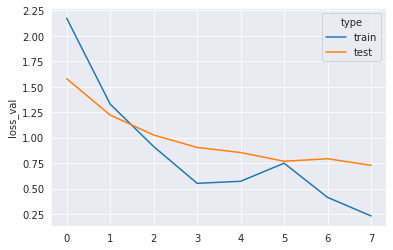

In [ ]:
visualize_losses()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  if __name__ == '__main__':
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input d

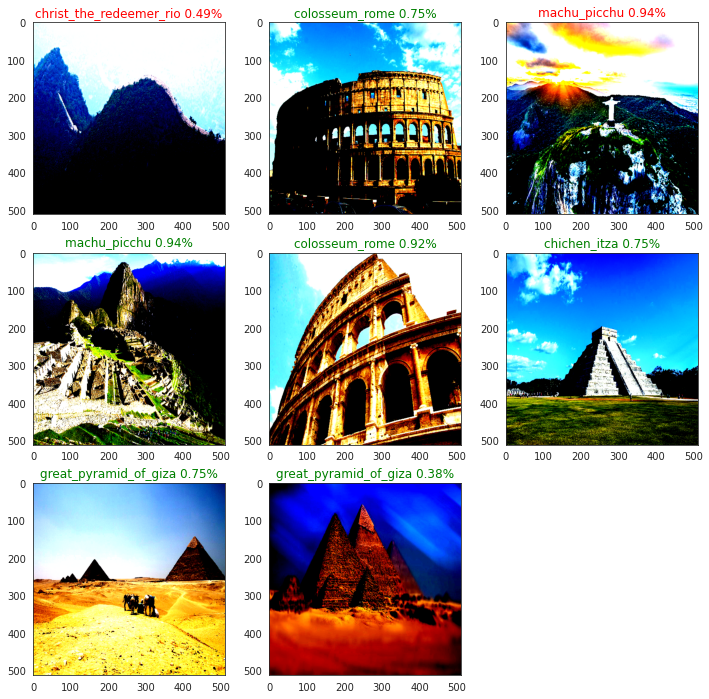

In [ ]:
dataiter = iter(test_loader)
images, labels = dataiter.next()
images = images.to(device)

outputs = net(images)
labels = np.array(labels)

# Cross Entropy loss already applied Softmax, now we need to do it manually
outputs_prob = F.softmax(outputs).detach().cpu().numpy()
# Get most likely class
outputs = np.argmax(outputs_prob, axis=1)
probabilities = np.max(outputs_prob, axis=1)

# Map the numeric values back to classes
txt_labels = list(train_dataset.class_to_idx.keys())
outputs = [txt_labels[i] for i in outputs]
labels = [txt_labels[i] for i in labels]
sns.set_style("white")
figsize = (12,12)
figure = plt.figure(figsize=figsize)

for i in range(batch_size):
  ax = figure.add_subplot(num_images_per_axis, num_images_per_axis, i+1)
  wonder_type = outputs[i]
  groundtruth = labels[i]

  if groundtruth == wonder_type:
    color = "green"
  else:
    color = "red"

  img = images[i]
  img = img.permute(1,2,0).detach().cpu().numpy()

  ax.set_title(wonder_type + f" {probabilities[i]:.2f}%", color=color)
  ax.imshow(img)

## Explainable AI - Understanding the predictions

### Filter and feature map visualization
Source: https://github.com/utkuozbulak/pytorch-cnn-visualizations
- The Functions below come from the github repository
- It contains different classes for creating CNN visualizations

In [ ]:
import os
import numpy as np
import torch
from torch.optim import Adam
from torchvision import models
from PIL import Image, ImageFilter
from torch.autograd import Variable
import copy


def preprocess_image(pil_im, resize_im=True, img_size=224):
    """
        Processes image for CNNs
    Args:
        PIL_img (PIL_img): PIL Image or numpy array to process
        resize_im (bool): Resize to 224 or not
    returns:
        im_as_var (torch variable): Variable that contains processed float tensor
    """
    
    # mean and std list for channels (Imagenet)
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    #ensure or transform incoming image to PIL image
    if type(pil_im) != Image.Image:
        try:
            pil_im = Image.fromarray(pil_im)
        except Exception as e:
            print("could not transform PIL_img to a PIL Image object. Please check input.")

    # Resize image
    if resize_im:
        pil_im = pil_im.resize((img_size, img_size), Image.ANTIALIAS)

    im_as_arr = np.float32(pil_im)
    im_as_arr = im_as_arr.transpose(2, 0, 1)  # Convert array to D,W,H
    # Normalize the channels
    for channel, _ in enumerate(im_as_arr):
        im_as_arr[channel] /= 255
        im_as_arr[channel] -= mean[channel]
        im_as_arr[channel] /= std[channel]
    # Convert to float tensor
    im_as_ten = torch.from_numpy(im_as_arr).float()
    # Add one more channel to the beginning. 
    im_as_ten.unsqueeze_(0)
    # Convert to Pytorch variable
    im_as_var = Variable(im_as_ten, requires_grad=True)
    return im_as_var

def recreate_image(im_as_var):
  """
      Recreates images from a torch variable, sort of reverse preprocessing
  Args:
      im_as_var (torch variable): Image to recreate
  returns:
      recreated_im (numpy arr): Recreated image in array
  """
  reverse_mean = [-0.485, -0.456, -0.406]
  reverse_std = [1/0.229, 1/0.224, 1/0.225]
  recreated_im = copy.copy(im_as_var.data.numpy()[0])
  for c in range(3):
      recreated_im[c] /= reverse_std[c]
      recreated_im[c] -= reverse_mean[c]
  recreated_im[recreated_im > 1] = 1
  recreated_im[recreated_im < 0] = 0
  recreated_im = np.round(recreated_im * 255)

  recreated_im = np.uint8(recreated_im).transpose(1, 2, 0)
  return recreated_im


class CNNLayerVisualization():
    """
        Produces an image that minimizes the loss of a convolution
        operation for a specific layer and filter
    """
    def __init__(self, model, selected_layer, selected_filter):
        self.model = model
        self.model.eval()
        self.selected_layer = selected_layer
        self.selected_filter = selected_filter
        self.conv_output = 0

    def hook_layer(self):
        def hook_function(module, grad_in, grad_out):
            # Gets the conv output of the selected filter (from selected layer)
            self.conv_output = grad_out[0, self.selected_filter]
        # Hook the selected layer
        self.model[self.selected_layer].register_forward_hook(hook_function)

    def visualise_layer_with_hooks(self):
        # Hook the selected layer
        self.hook_layer()
        # Generate a random image
        random_image = np.uint8(np.random.uniform(150, 180, (50, 50, 3)))
        # Process image and return variable
        processed_image = preprocess_image(random_image, False)
        # Define optimizer for the image
        optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)
        for i in range(1, 31):
            # Idea: https://towardsdatascience.com/how-to-visualize-convolutional-features-in-40-lines-of-code-70b7d87b0030
            if i % 4 == 0:
                # We have to convert the image back to int here
                recreated = recreate_image(processed_image)

                # Upscale image
                pil_im = Image.fromarray(recreated)
                current_dim = recreated.shape[1]
                new_dim = np.uint8(np.floor(current_dim * 1.2))
                pil_im = pil_im.resize((new_dim, new_dim), Image.ANTIALIAS)
                processed_image = preprocess_image(pil_im, False)
                optimizer = Adam([processed_image], lr=0.1, weight_decay=1e-6)

            optimizer.zero_grad()
            # Assign create image to a variable to move forward in the model
            x = processed_image.to(device)
            for index, layer in enumerate(self.model):
                # Forward pass layer by layer
                # x is not used after this point because it is only needed to trigger
                # the forward hook function
                x = layer(x)
                # Only need to forward until the selected layer is reached
                if index == self.selected_layer:
                    # (forward hook function triggered)
                    break
            # Loss function is the mean of the output of the selected layer/filter
            # We try to minimize the mean of the output of that specific filter
            loss = -torch.mean(self.conv_output).cpu()
            # Backward
            loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.created_image = recreate_image(processed_image)
          
        # Display the final image
        plt.imshow(self.created_image)
        plt.show()
        return self.created_image

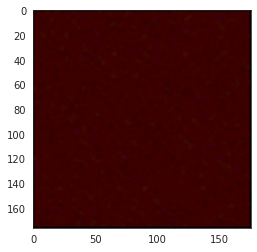

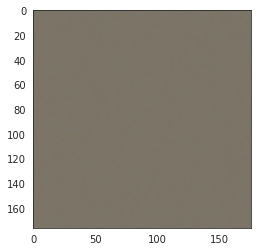

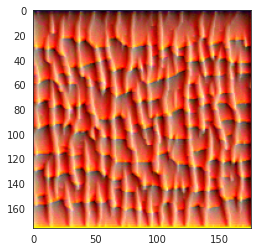

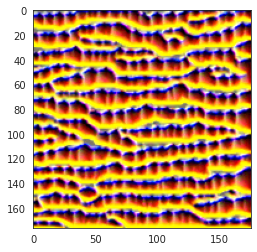

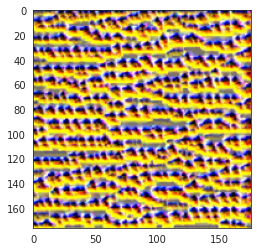

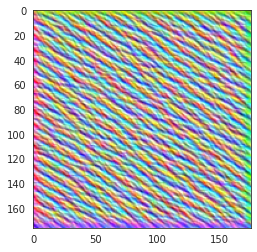

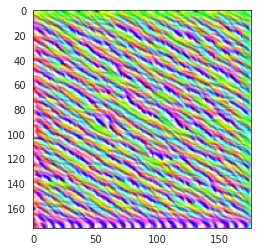

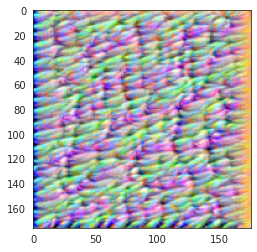

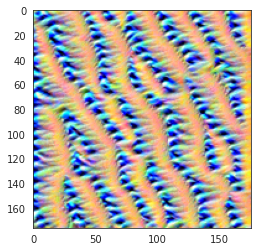

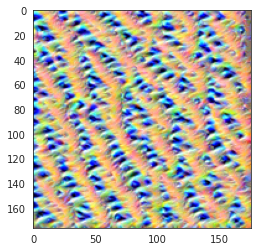

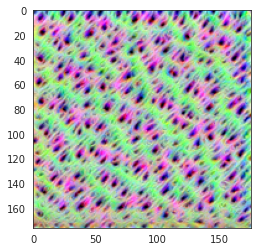

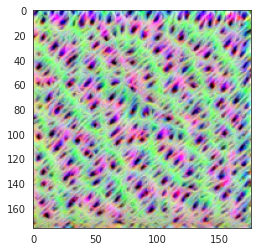

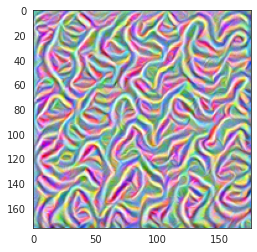

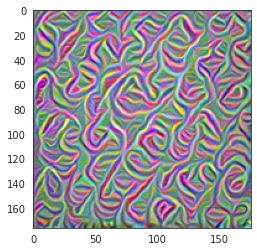

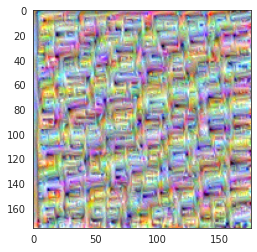

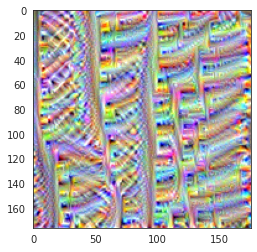

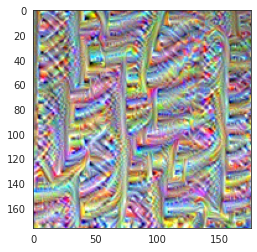

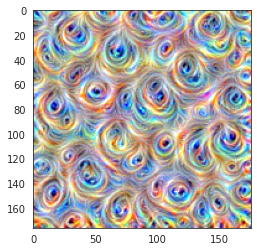

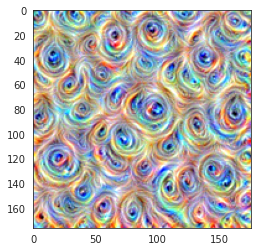

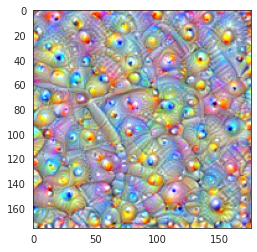

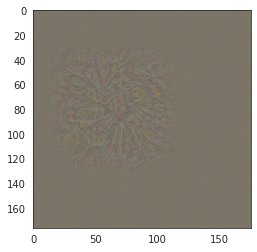

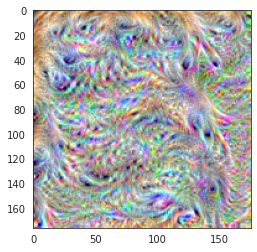

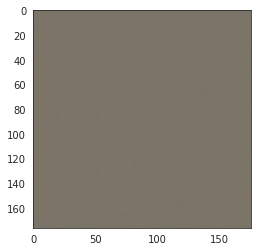

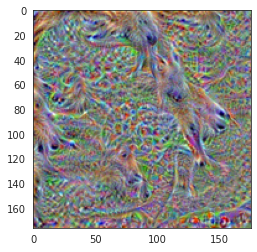

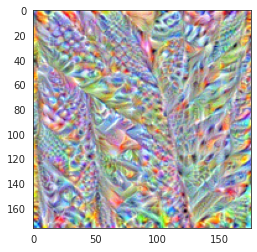

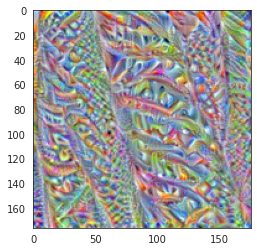

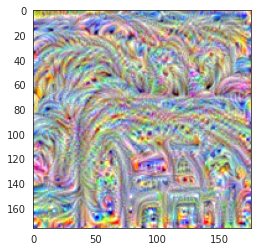

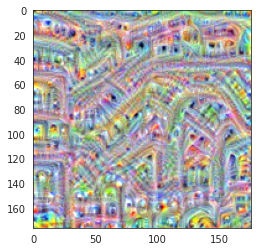

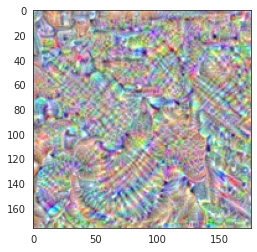

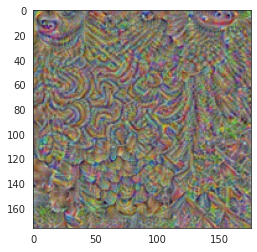

In [ ]:
# Which of the feature maps
filter_pos = 12 
# Fully connected layer is not needed
pretrained_model = net.pretrained.features

for layer in range(30):
  cnn_layer = layer
  layer_vis = CNNLayerVisualization(pretrained_model, cnn_layer, filter_pos)
  # Layer visualization with pytorch hooks
  layer_vis.visualise_layer_with_hooks()

### Gradient Class Activation Heatmap (GradCAM)

In [ ]:
from PIL import Image
import numpy as np
import torch

class CamExtractor():
    """
        Extracts cam features from the model
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None

    def save_gradient(self, grad):
        self.gradients = grad

    def forward_pass_on_convolutions(self, x):
        """
            Does a forward pass on convolutions, hooks the function at given layer
        """
        conv_output = None
        for module_pos, module in self.model.features._modules.items():
            x = module(x)  # Forward
            if int(module_pos) == self.target_layer:
                x.register_hook(self.save_gradient)
                conv_output = x  # Save the convolution output on that layer
        return conv_output, x

    def forward_pass(self, x):
        """
            Does a full forward pass on the model
        """
        # Forward pass on the convolutions
        conv_output, x = self.forward_pass_on_convolutions(x)
        x = x.view(x.size(0), -1)  # Flatten
        # Forward pass on the classifier
        x = self.model.classifier(x)
        return conv_output, x


class GradCam():
    """
        Produces class activation map
    """
    def __init__(self, model, target_layer):
        self.model = model
        self.model.eval()
        # Define extractor
        self.extractor = CamExtractor(self.model, target_layer)

    def generate_cam(self, input_image, target_class=None):
        # Full forward pass
        # conv_output is the output of convolutions at specified layer
        # model_output is the final output of the model (1, 8)
        conv_output, model_output = self.extractor.forward_pass(input_image)
        # If no target class, take the model prediction
        if target_class is None:
            target_class = np.argmax(model_output.data.numpy())
        # Target for backprop
        one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
        one_hot_output[0][target_class] = 1
        one_hot_output = one_hot_output.to(device)
        # Zero grads
        self.model.features.zero_grad()
        self.model.classifier.zero_grad()
        # Backward pass with specified target
        model_output.backward(gradient=one_hot_output, retain_graph=True)
        # Get hooked gradients
        guided_gradients = self.extractor.gradients.data.cpu().numpy()[0]
        # Get convolution outputs
        target = conv_output.data.cpu().numpy()[0]
        # Get weights from gradients
        weights = np.mean(guided_gradients, axis=(1, 2))  # Take averages for each gradient
        # Create empty numpy array for cam
        cam = np.ones(target.shape[1:], dtype=np.float32)
        # Multiply each weight with its conv output and then, sum
        for i, w in enumerate(weights):
            cam += w * target[i, :, :]
        cam = np.maximum(cam, 0) # This equals ReLU
        cam = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))  # Normalize between 0-1
        cam = np.uint8(cam * 255)  # Scale between 0-255 to visualize
        cam = np.uint8(Image.fromarray(cam).resize((input_image.shape[2],
                       input_image.shape[3]), Image.ANTIALIAS))/255
        
        return cam

In [ ]:
test_dataset.class_to_idx

{'chichen_itza': 0,
 'christ_the_redeemer_rio': 1,
 'city_of_petra': 2,
 'colosseum_rome': 3,
 'great_pyramid_of_giza': 4,
 'great_wall_of_china': 5,
 'machu_picchu': 6,
 'taj_mahal': 7}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


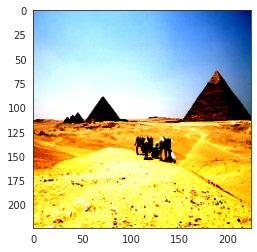

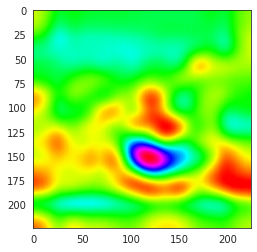

In [ ]:
import matplotlib.cm as mpl_color_map

# Input
#sample_path = '/content/google_drive/My Drive/DeepFindr/CNN/test/taj_mahal/architecture-4378_1280.jpg'
# Thats very interesting!!
sample_path = '/content/google_drive/My Drive/DeepFindr/CNN/test/great_pyramid_of_giza/cairo-1051380_1280.jpg'

original_image = Image.open(sample_path).convert('RGB')
prep_img = preprocess_image(original_image).to(device)
prep_img_numpy = prep_img.permute(0,2,3,1).detach().cpu()[0]
target_class = 7 # Needs to be adjusted!!
pretrained_model = net.pretrained

# Grad cam - make sure to select the relevant layer!!
grad_cam = GradCam(pretrained_model, target_layer=28)
# Generate cam mask
cam = grad_cam.generate_cam(prep_img, target_class)

# Get colormap
color_map = mpl_color_map.get_cmap('hsv')
no_trans_heatmap = color_map(cam)

# Change alpha channel in colormap to make sure original image is displayed
heatmap = copy.copy(no_trans_heatmap)
heatmap[:, :, 3] = 0.4
heatmap = Image.fromarray((heatmap*255).astype(np.uint8))
no_trans_heatmap = Image.fromarray((no_trans_heatmap*255).astype(np.uint8))

plt.imshow(prep_img_numpy)
plt.show()
plt.imshow(no_trans_heatmap)
plt.show()

### Adversarial Attacks
Source: https://github.com/utkuozbulak/pytorch-cnn-adversarial-attacks

In [ ]:
import os
import cv2
from torch.optim import SGD
from torchvision import models
from torch.nn import functional

class DisguisedFoolingSampleGeneration():
    """
        Produces an image that maximizes a certain class with gradient ascent, breaks as soon as
        the target prediction confidence is captured
    """
    def __init__(self, model, initial_image, target_class, minimum_confidence):
        self.model = model
        self.model.eval()
        self.target_class = target_class
        self.minimum_confidence = minimum_confidence
        # Generate a random image
        self.initial_image = initial_image

    def generate(self):
        for i in range(1, 500):
            # Process image and return variable
            self.processed_image = preprocess_image(self.initial_image)
            # Define optimizer for the image
            optimizer = SGD([self.processed_image], lr=0.7)
            # Forward
            output = self.model(self.processed_image.to(device))
            # Get confidence from softmax
            target_confidence = functional.softmax(output)[0][self.target_class].data.cpu().numpy()
            if target_confidence > self.minimum_confidence:
                # Preprocess image
                confirmation_processed_image = preprocess_image(confirmation_image).to(device)
                # Get prediction
                confirmation_output = self.model(confirmation_processed_image)
                # Get confidence
                softmax_confirmation = \
                    functional.softmax(confirmation_output)[0][self.target_class].data.cpu().numpy()
                if softmax_confirmation > self.minimum_confidence:
                    print('Generated disguised fooling image with', "{0:.2f}".format(softmax_confirmation),
                          'confidence at', str(i) + 'th iteration.')
                    break
            # Target specific class - the smaller the negative probability, the better
            class_loss = -output[0, self.target_class]
            print('Iteration:', str(i), 'Target confidence', "{0:.4f}".format(target_confidence))
            # Zero grads
            self.model.zero_grad()
            # Backward
            class_loss.backward()
            # Update image
            optimizer.step()
            # Recreate image
            self.initial_image = recreate_image(self.processed_image)
            confirmation_image = self.initial_image
        return self.processed_image.detach().permute(0,2,3,1).numpy()[0]

In [ ]:
test_dataset.class_to_idx

{'chichen_itza': 0,
 'christ_the_redeemer_rio': 1,
 'city_of_petra': 2,
 'colosseum_rome': 3,
 'great_pyramid_of_giza': 4,
 'great_wall_of_china': 5,
 'machu_picchu': 6,
 'taj_mahal': 7}

In [ ]:
#sample_path = '/content/google_drive/My Drive/DeepFindr/CNN/test/great_pyramid_of_giza/cairo-1051380_1280.jpg' # with 0
sample_path = '/content/google_drive/My Drive/DeepFindr/CNN/test/chichen_itza/chichen-itza-683193_1280.jpg' # with 4
#sample_path = '/content/google_drive/My Drive/DeepFindr/CNN/test/colosseum_rome/italy-2478805_1280.jpg' # with 2
original_image = Image.open(sample_path).convert('RGB')
prep_img = preprocess_image(original_image).detach().permute(0,2,3,1).numpy()[0]
pretrained_model = net.pretrained

# This is the class we want the model to predict
fooling_target_class = 4
min_confidence = 0.9
fool = DisguisedFoolingSampleGeneration(pretrained_model,
                                        original_image,
                                        fooling_target_class,
                                        min_confidence)
generated_image = fool.generate()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Iteration: 1 Target confidence 0.0580
Iteration: 2 Target confidence 0.2603
Iteration: 3 Target confidence 0.4529
Iteration: 4 Target confidence 0.6248
Iteration: 5 Target confidence 0.7396
Iteration: 6 Target confidence 0.8229
Iteration: 7 Target confidence 0.8847
Generated disguised fooling image with 0.93 confidence at 8th iteration.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:36: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


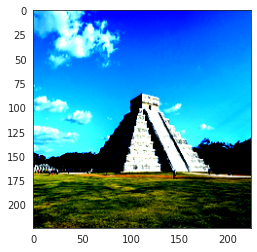

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


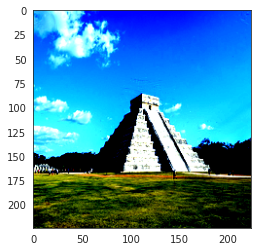

In [ ]:
# Original image (preprocessed)
plt.imshow(prep_img)
plt.show()
# Adversarial sample
plt.imshow(generated_image)
plt.show()

Let's plug it into the model to see if this is true... :O

In [ ]:
# Original image
output = net(torch.Tensor([prep_img]).permute(0,3,1,2).to(device))
outputs_prob = F.softmax(output)
output_to_label(outputs_prob)[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


0

In [ ]:
# Adversarial sample
output = net(torch.Tensor([generated_image]).permute(0,3,1,2).to(device))
outputs_prob = F.softmax(output)
output_to_label(outputs_prob)[0]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:84: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


4